In [4]:
import sys
import os
import json
import torch
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import energy_data_lab as edl

from types import SimpleNamespace
from torch.utils.data import DataLoader, Subset

# Local imports
#sys.path.append(os.path.abspath(os.path.join('..', 'models')))
#sys.path.append(os.path.abspath(os.path.join('..', 'data', 'datasets')))
from models import Model as MLP
from datasets import PenmanshielDataset

In [6]:
# load hyperparameters
with open("../hyperparameters/mlp.json", "r") as f:
    hp = json.load(f)
args = SimpleNamespace(**hp)

In [7]:
# load data
df = pd.read_csv("../data/cleaned/Cleaned_Data.csv", index_col=0, parse_dates=True)
dataset = PenmanshielDataset(
        data_file="../data/cleaned/Cleaned_Data.csv",
        lookback_timesteps=args.lookback_timesteps,
        forecast_timesteps=args.forecast_timesteps,
    )
n = len(dataset)
n_train = int(args.train_share * n) 
n_val = int(args.val_share * n)  
n_test = n - n_train - n_val
df_test = df.iloc[n_train + n_val:]
dataset_test = Subset(dataset, range(n_train + n_val, n_train + n_val + n_test))
loader_test = DataLoader(dataset_test)

In [9]:
model = MLP(args)
torch.serialization.add_safe_globals([model])
model.load_state_dict(torch.load("../models/mlp.pth", weights_only=True))
model.eval()

Model(
  (mlp): ModuleList(
    (0): MLPLayer(
      (hidden): Linear(in_features=48, out_features=512, bias=True)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (1): MLPLayer(
      (hidden): Linear(in_features=512, out_features=512, bias=True)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (projection): Linear(in_features=512, out_features=6, bias=True)
)

In [10]:
# Compute test MSE and extract forecasts for visualization
df_results_list = []
actual_onestepahead = np.array([])
actual_twostepsahead = np.array([])
actual_threestepsahead = np.array([])
actual_fourstepsahead = np.array([])
actual_fivestepsahead = np.array([])
actual_sixstepsahead = np.array([])
predicted_onestepahead = np.array([])
predicted_twostepsahead = np.array([])
predicted_threestepsahead = np.array([])
predicted_fourstepsahead = np.array([])
predicted_fivestepsahead = np.array([])
predicted_sixstepsahead = np.array([])
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.MSELoss()
model.eval()
loss_list = []
for i, (X, y) in enumerate(loader_test):
    index_window = df_test.index[i : i + args.lookback_timesteps + args.forecast_timesteps]
    index_forecast = df_test.index[i + args.lookback_timesteps : i + args.lookback_timesteps + args.forecast_timesteps]
    df_i = pd.DataFrame({
        "Actual": df_test.loc[index_window, "Power (kW)"] * 28856.585504080267,
        "Predicted": None
        },
        index=index_window)
    X = X.to(device=args.device)
    y = y.to(device=args.device)
    y_np = y.cpu().detach().numpy().flatten()
    y_pred = model(X)
    y_pred_np = y_pred.cpu().detach().numpy().flatten()
    actual_onestepahead = np.append(actual_onestepahead, y_np[0])
    actual_twostepsahead = np.append(actual_twostepsahead, y_np[1])
    actual_threestepsahead = np.append(actual_threestepsahead, y_np[2])
    actual_fourstepsahead = np.append(actual_fourstepsahead, y_np[3])
    actual_fivestepsahead = np.append(actual_fivestepsahead, y_np[4])
    actual_sixstepsahead = np.append(actual_sixstepsahead, y_np[5])
    predicted_onestepahead = np.append(predicted_onestepahead, y_pred_np[0])
    predicted_twostepsahead = np.append(predicted_twostepsahead, y_pred_np[1])
    predicted_threestepsahead = np.append(predicted_threestepsahead, y_pred_np[2])
    predicted_fourstepsahead = np.append(predicted_fourstepsahead, y_pred_np[3])
    predicted_fivestepsahead = np.append(predicted_fivestepsahead, y_pred_np[4])
    predicted_sixstepsahead = np.append(predicted_sixstepsahead, y_pred_np[5])
    # concatenate y_pred with leading Nones to match the index of df_i
    y_pred_padded = np.concatenate([np.array([None]*args.lookback_timesteps), y_pred_np* 28856.585504080267], axis=None)
    df_i["Predicted"] = y_pred_padded
    df_results_list.append(df_i)
    loss = loss_fn(y_pred, y)
    loss_list.append(loss.cpu().item())

In [11]:
print(f"Test MSE: {sum(loss_list)/len(loss_list):.4f}")
print(f"Test RMSE: {np.sqrt(sum(loss_list)/len(loss_list)):.4f}")

Test MSE: 0.0196
Test RMSE: 0.1400


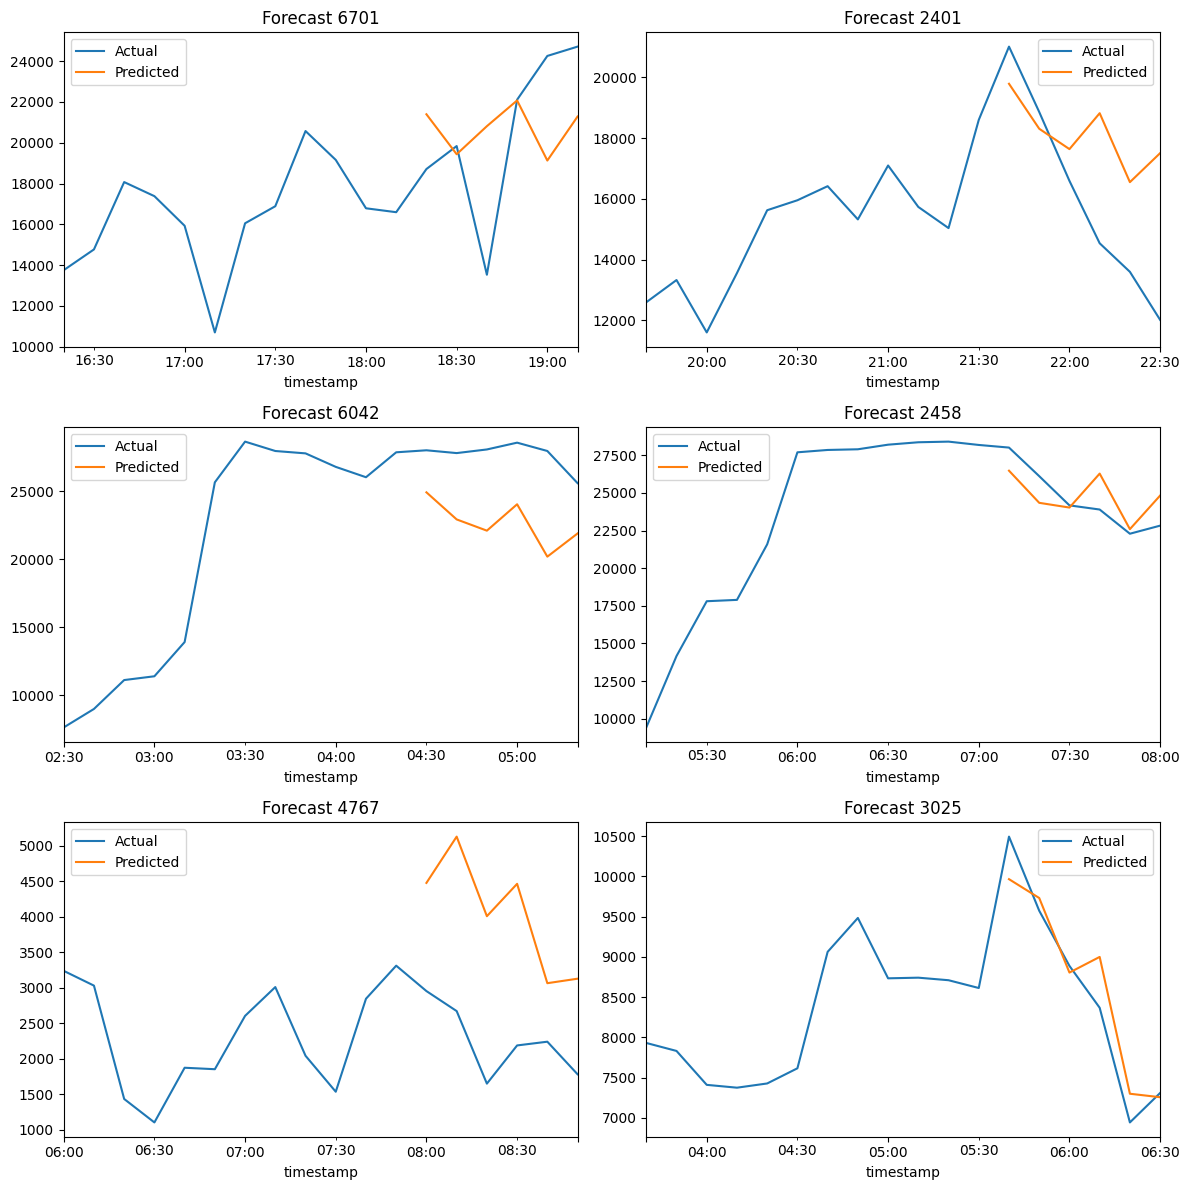

In [12]:
# draw six random integers between 0 and len(df_results_list)
n_dfs = len(df_results_list)
indices = random.sample(range(n_dfs), 6)
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, index in enumerate(indices):
    row = i // 2
    col = i % 2
    df_results_list[index].plot(ax=ax[row, col], title=f"Forecast {index}")
plt.tight_layout()
plt.show()

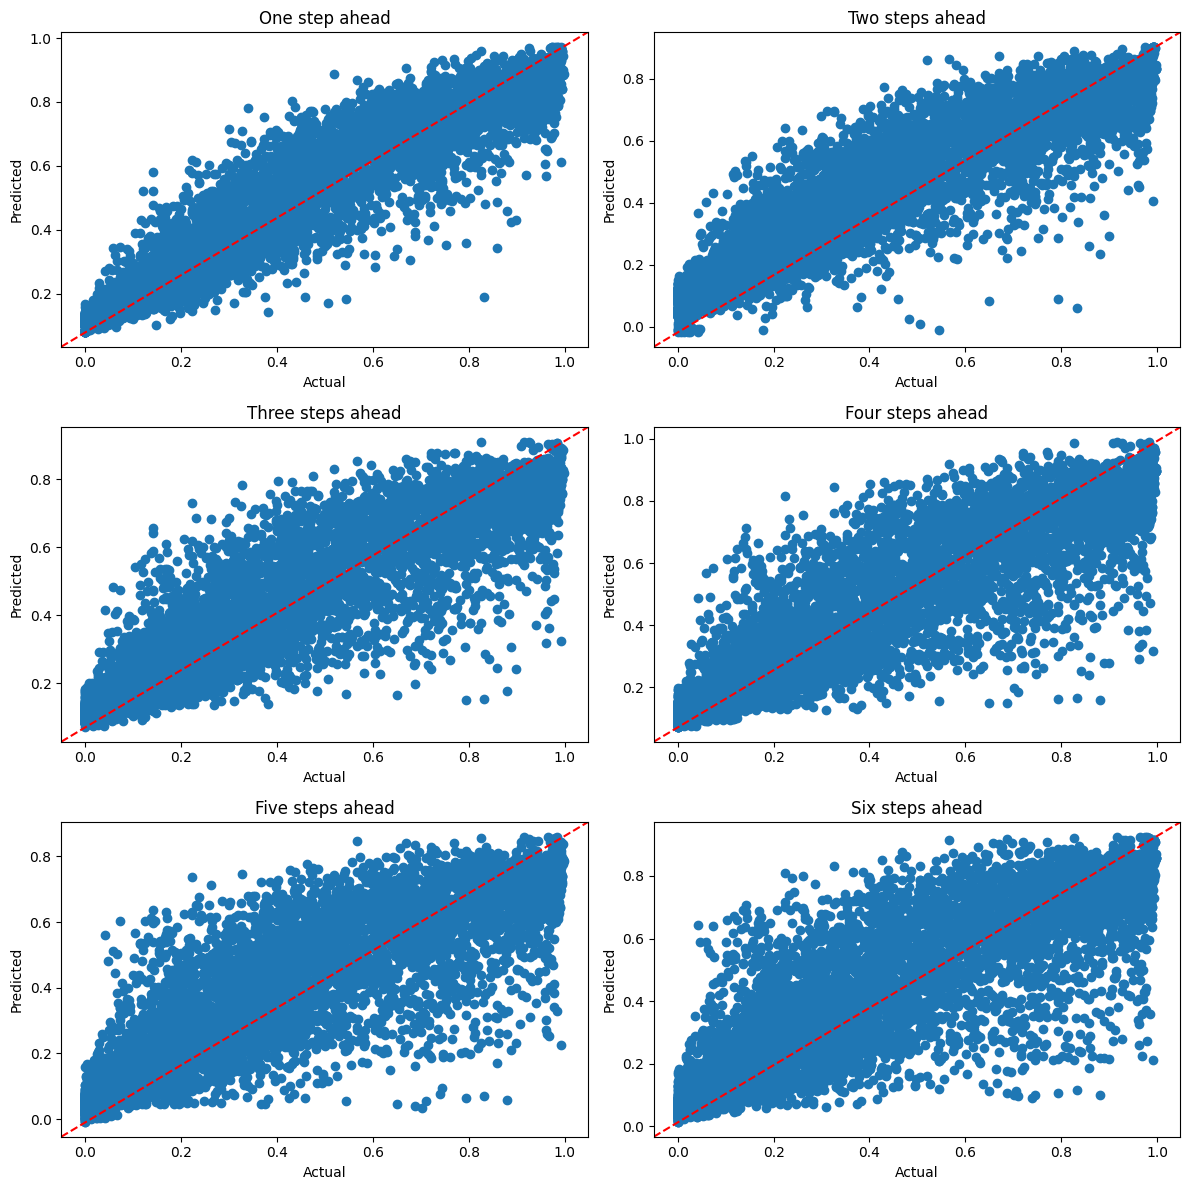

In [13]:
# Plot predicted vs. actual, different plots for different forecast horizons
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].scatter(actual_onestepahead, predicted_onestepahead)
# add diagnonal line
ax[0, 0].plot([0, 1], [0, 1], transform=ax[0, 0].transAxes, ls="--", c="red")
ax[0, 0].set_title("One step ahead")
ax[0, 0].set_xlabel("Actual")
ax[0, 0].set_ylabel("Predicted")
ax[0, 1].scatter(actual_twostepsahead, predicted_twostepsahead)
ax[0, 1].plot([0, 1], [0, 1], transform=ax[0, 1].transAxes, ls="--", c="red")
ax[0, 1].set_title("Two steps ahead")
ax[0, 1].set_xlabel("Actual")
ax[0, 1].set_ylabel("Predicted")
ax[1, 0].scatter(actual_threestepsahead, predicted_threestepsahead)
ax[1, 0].plot([0, 1], [0, 1], transform=ax[1, 0].transAxes, ls="--", c="red")
ax[1, 0].set_title("Three steps ahead")
ax[1, 0].set_xlabel("Actual")
ax[1, 0].set_ylabel("Predicted")
ax[1, 1].scatter(actual_fourstepsahead, predicted_fourstepsahead)
ax[1, 1].plot([0, 1], [0, 1], transform=ax[1, 1].transAxes, ls="--", c="red")
ax[1, 1].set_title("Four steps ahead")
ax[1, 1].set_xlabel("Actual")
ax[1, 1].set_ylabel("Predicted")
ax[2, 0].scatter(actual_fivestepsahead, predicted_fivestepsahead)
ax[2, 0].plot([0, 1], [0, 1], transform=ax[2, 0].transAxes, ls="--", c="red")
ax[2, 0].set_title("Five steps ahead")
ax[2, 0].set_xlabel("Actual")
ax[2, 0].set_ylabel("Predicted")
ax[2, 1].scatter(actual_sixstepsahead, predicted_sixstepsahead)
ax[2, 1].plot([0, 1], [0, 1], transform=ax[2, 1].transAxes, ls="--", c="red")
ax[2, 1].set_title("Six steps ahead")
ax[2, 1].set_xlabel("Actual")
ax[2, 1].set_ylabel("Predicted")
plt.tight_layout()
plt.show()

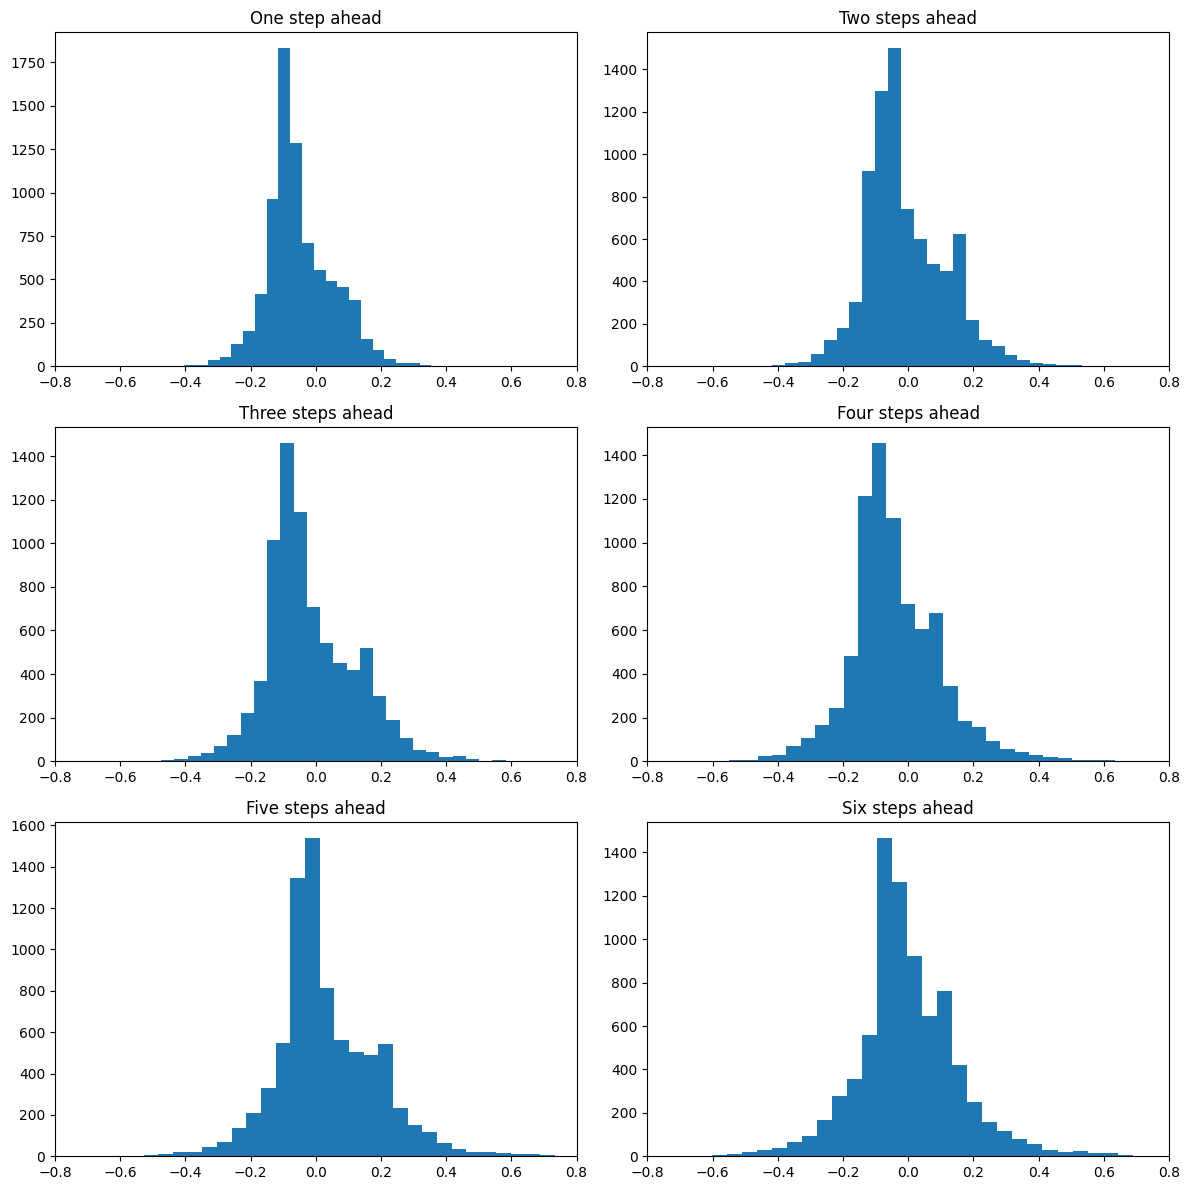

In [14]:
# plot residual histograms for different forecast horizons
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
residual_onestepahead = actual_onestepahead - predicted_onestepahead
residual_twostepsahead = actual_twostepsahead - predicted_twostepsahead
residual_threestepsahead = actual_threestepsahead - predicted_threestepsahead
residual_fourstepsahead = actual_fourstepsahead - predicted_fourstepsahead
residual_fivestepsahead = actual_fivestepsahead - predicted_fivestepsahead
residual_sixstepsahead = actual_sixstepsahead - predicted_sixstepsahead
ax[0, 0].hist(residual_onestepahead, bins=30)
# make sure the x-axis is the same for all histograms
ax[0, 0].set_xlim(-.8, .8)
ax[0, 0].set_title("One step ahead")
ax[0, 1].hist(residual_twostepsahead, bins=30)
ax[0, 1].set_xlim(-.8, .8)
ax[0, 1].set_title("Two steps ahead")
ax[1, 0].hist(residual_threestepsahead, bins=30)
ax[1, 0].set_xlim(-.8, .8)
ax[1, 0].set_title("Three steps ahead")
ax[1, 1].hist(residual_fourstepsahead, bins=30)
ax[1, 1].set_xlim(-.8, .8)
ax[1, 1].set_title("Four steps ahead")
ax[2, 0].hist(residual_fivestepsahead, bins=30)
ax[2, 0].set_xlim(-.8, .8)
ax[2, 0].set_title("Five steps ahead")
ax[2, 1].hist(residual_sixstepsahead, bins=30)
ax[2, 1].set_xlim(-.8, .8)
ax[2, 1].set_title("Six steps ahead")
plt.tight_layout()
plt.show()